In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 


# Exploration  de la data 

In [2]:
import os
from PIL import Image
from pathlib import Path

In [3]:
data_dir = Path("Data")

dataset_info = {}

for split in ["Train_Data", "Test_Data"]:
    split_path = data_dir / split
    dataset_info[split] = {}
    for class_name in ["_Fire", "Non_Fire"]:
        class_path = split_path / class_name
        image_files = list(class_path.glob("*.jpg"))  # Or *.png, *.jpeg, etc.
        count = len(image_files)
        dimensions = []
        for image_file in image_files[:5]:
            try:
                with Image.open(image_file) as img:
                    dimensions.append(img.size + (len(img.getbands()),))  # (width, height, channels)
            except Exception as e:
                print(f"Error opening image {image_file}: {e}")
        dataset_info[split][class_name] = {"count": count, "dimensions": dimensions}


for split, classes in dataset_info.items():
    print(f"\n{split.upper()} DATASET")
    for class_name, info in classes.items():
        count = info.get('count', 0)  # Use .get() with default value
        dimensions = info.get('dimensions', []) #Use .get() with default value
        print(f" Classe '{class_name}': {count} images")
        if dimensions: # check if dimension list is not empty
            print(f" Dimensions (exemples): {dimensions[:5]}") # print only the first 5 dimensions
        else:
            print("No dimensions available")



TRAIN_DATA DATASET
 Classe '_Fire': 2111 images
 Dimensions (exemples): [(250, 250, 3), (250, 250, 3), (250, 250, 3), (250, 250, 3), (194, 260, 3)]
 Classe 'Non_Fire': 2500 images
 Dimensions (exemples): [(250, 250, 3), (250, 250, 3), (250, 250, 3), (250, 250, 3), (600, 403, 3)]

TEST_DATA DATASET
 Classe '_Fire': 24 images
 Dimensions (exemples): [(1200, 749, 3), (760, 368, 3), (1440, 810, 3), (286, 176, 3), (1200, 675, 3)]
 Classe 'Non_Fire': 25 images
 Dimensions (exemples): [(800, 600, 3), (1152, 1536, 3), (930, 558, 3), (545, 482, 4), (700, 525, 3)]


## Clean the data 

In [4]:
import os
from PIL import Image, UnidentifiedImageError, ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [5]:
def clean_image_dataset(data_dir):
    """
    Cleans a dataset of images by removing corrupted or unreadable files.

    Args:
        data_dir: The root directory of the dataset (containing subdirectories for classes).
    """
    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):
            print(f"Checking {class_name} directory...")
            for filename in os.listdir(class_dir):
                if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')): # Add other extensions if needed
                    image_path = os.path.join(class_dir, filename)
                    try:
                        img = Image.open(image_path)
                        img.verify()  # Verify image integrity
                        img.close() # Close the file after verification
                    except (FileNotFoundError, UnidentifiedImageError, OSError) as e:
                        print(f"Corrupted or unreadable image found: {image_path}. Removing...")
                        try:
                            os.remove(image_path)
                            print(f"Successfully removed: {image_path}")
                        except OSError as e:
                            print(f"Error removing file: {e}")
                    except Exception as e:
                        print(f"Other error: {e} with image {image_path}")


In [6]:
# Example usage:
train_data_dir = "Data/Train_Data" # Replace with your training data directory
test_data_dir = "Data/Test_Data" # Replace with your test data directory

clean_image_dataset(train_data_dir)
clean_image_dataset(test_data_dir)

print("Cleaning process finished.")

Checking Non_Fire directory...
Checking _Fire directory...
Checking Non_Fire directory...
Checking _Fire directory...
Cleaning process finished.


In [7]:
def count_images_per_class(data_dir):
    """Counts the number of images in each class within a directory.

    Args:
        data_dir (Path): The path to the root directory containing subdirectories for splits and classes.

    Returns:
        dict: A dictionary where keys are split names ("Train_Data", "Test_Data") and values are dictionaries containing class names as keys and image counts as values.
        Returns None if the data directory does not exist.
    """

    if not data_dir.exists():
        print(f"Error: Data directory '{data_dir}' does not exist.")
        return None

    dataset_info = {}
    for split in ["Train_Data", "Test_Data"]:
        split_path = data_dir / split
        dataset_info[split] = {}
        for class_name in ["_Fire", "Non_Fire"]:
            class_path = split_path / class_name
            image_files = list(class_path.glob("*.*"))  # Count all files in the directory
            count = len(image_files)
            dataset_info[split][class_name] = count

    return dataset_info


data_dir = Path("Data")
dataset_info = count_images_per_class(data_dir)

if dataset_info:
    for split, classes in dataset_info.items():
        print(f"\n{split.upper()} DATASET")
        for class_name, count in classes.items():
            print(f" Classe '{class_name}': {count} images")
else:
    print("No data found or an error occurred.")



TRAIN_DATA DATASET
 Classe '_Fire': 2111 images
 Classe 'Non_Fire': 2500 images

TEST_DATA DATASET
 Classe '_Fire': 24 images
 Classe 'Non_Fire': 25 images


## Load the data 

In [8]:
# Chemin vers le répertoire principal des données
data_dir = 'Data'
train_dir = os.path.join(data_dir, 'Train_Data')
test_dir = os.path.join(data_dir, 'Test_Data')

# Paramètres
img_height, img_width = 224, 224  # Taille des images (à adapter selon votre besoin)
batch_size = 32 #Taille des batchs
validation_split = 0.15 # Pourcentage de validation


In [9]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',  # Infère les labels à partir des noms de dossiers
    label_mode='binary', #Labels binaires car 2 classes (Fire et Non_Fire)
    image_size=(img_height, img_width),
    batch_size=batch_size,
    seed=123, #Important pour la reproductibilité
    validation_split=validation_split,
    subset='training'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    seed=123,
    validation_split=validation_split,
    subset='validation'
)
# # Chargement des données de test
# test_dir = os.path.join(data_dir, 'Test_Data')
# test_ds = tf.keras.utils.image_dataset_from_directory(
#     test_dir,
#     labels='inferred',
#     label_mode='binary',
#     image_size=(img_height, img_width),
#     batch_size=batch_size
# )

Found 4611 files belonging to 2 classes.
Using 3920 files for training.
Found 4611 files belonging to 2 classes.
Using 691 files for validation.


In [10]:
# Affichage des classes et du nombre d'images
class_names = train_ds.class_names
print("Classes:", class_names)

Classes: ['Non_Fire', '_Fire']


### 0 pour Non fire 
### 1 pour fire 

In [11]:
print("Nombre de batchs d'entraînement :", len(train_ds))
print("Nombre de batchs de validation :", len(val_ds))
# print("Nombre de batchs de test :", len(test_ds))

Nombre de batchs d'entraînement : 123
Nombre de batchs de validation : 22


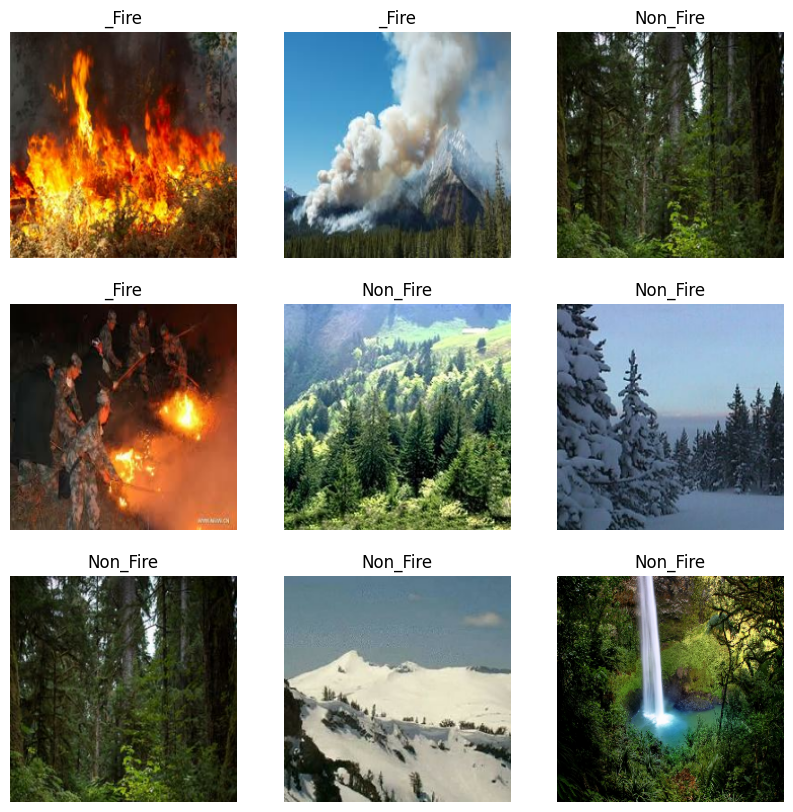

In [12]:
# Exemple d'affichage d'images (pour vérifier le chargement)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])]) # Conversion en int car les labels sont des tensors
        plt.axis("off")
plt.show()

### Normalization de la data

In [13]:
from tensorflow.keras.layers import Rescaling

normalization_layer = Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
# test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))


### construction du modele

In [14]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import  Flatten,MaxPooling2D,Dense , Conv2D , Dropout


In [15]:
model = Sequential(
    [
        Conv2D(16,(3,3),activation='relu' , input_shape = (img_height, img_width , 3)),
        Dropout(0.2),
        MaxPooling2D((2,2)),
        Conv2D(32,(3,3),activation='relu'),
        Dropout(0.2),
        MaxPooling2D((2,2)),
        # Conv2D(64,(3,3),activation='relu'),
        # Dropout(0.2),
        # MaxPooling2D((2,2)),
        Flatten(),
        # Dense(64,activation='relu'),
        # Dropout(0.2),
        Dense(32,activation='relu'),
        Dropout(0.2),
        Dense(1 , activation='sigmoid')
   
    ]
 
)

c:\Users\Farouk\Desktop\CNN\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
model.compile(optimizer='adam' , loss='binary_crossentropy',metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 222, 222, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 109, 109, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 93312)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     2,986,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,991,137 (11.41 MB)

 Trainable params: 2,991,137 (11.41 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
from tensorflow.keras.callbacks import EarlyStopping,TensorBoard
import datetime

## set up the tensorboard
log_dir  = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorflow_callback = TensorBoard(log_dir=log_dir,histogram_freq=1)



In [20]:
history = model.fit(
    train_ds, validation_data = val_ds , epochs = 5,callbacks=[tensorflow_callback]
)

Epoch 1/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 21s 165ms/step - accuracy: 0.9632 - loss: 0.0951 - val_accuracy: 0.9436 - val_loss: 0.1564
Epoch 2/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 20s 163ms/step - accuracy: 0.9730 - loss: 0.0800 - val_accuracy: 0.9378 - val_loss: 0.1670
Epoch 3/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 20s 165ms/step - accuracy: 0.9768 - loss: 0.0611 - val_accuracy: 0.9334 - val_loss: 0.1542
Epoch 4/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 20s 165ms/step - accuracy: 0.9849 - loss: 0.0452 - val_accuracy: 0.9522 - val_loss: 0.1291
Epoch 5/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 20s 163ms/step - accuracy: 0.9872 - loss: 0.0357 - val_accuracy: 0.9624 - val_loss: 0.1218


In [21]:
model.save('model2.h5')

In [22]:
### Load Tensorboard Extension 

%load_ext tensorboard

In [23]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 22776), started 9:53:25 ago. (Use '!kill 22776' to kill it.)